In [1]:
%matplotlib inline 
import os
import pickle
import pyemma as py
import numpy as np 
import mdtraj as md
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import utils

## Load data from trajectory and generate features

In [4]:
trj_dir = '/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein'

In [5]:
trj_file = os.path.join(trj_dir, 'trp-cage_rmsdmin.dcd')
raw_file = os.path.join(trj_dir, 'trp-cage_raw.dcd')
pdb_file = os.path.join(trj_dir, '2JOF-0-protein.pdb')

In [6]:
trj = md.load(trj_file, top=pdb_file)
ref = md.load('2jof.pdb')

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [7]:
ca_atoms = trj.topology.select('name CA')
ref_ca_atoms = ref.topology.select('name CA')

In [8]:
trj_ca_slice = trj.atom_slice(ca_atoms)
ref_ca_slice = ref.atom_slice(ref_ca_atoms)

In [9]:
torsions_feat = py.coordinates.featurizer(pdb_file)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = py.coordinates.load(trj_file, features=torsions_feat)

ca_distances_feat = py.coordinates.featurizer(pdb_file)
ca_distances_feat.add_distances_ca(periodic=False)
ca_distances_data = py.coordinates.load(trj_file, features=ca_distances_feat)

combined_feat = py.coordinates.featurizer(pdb_file)
combined_feat.add_backbone_torsions(cossin=True, periodic=False)
combined_feat.add_sidechain_torsions(cossin=True, which=['chi1'], periodic=False)
combined_feat.add_distances_ca(periodic=False)
combined_data = py.coordinates.load(trj_file, features=combined_feat)

allatom_feat = py.coordinates.featurizer(pdb_file)
allatom_feat.add_all()
allatom_data = py.coordinates.load(trj_file, features=allatom_feat)

In [11]:
my_ca_distances_feat = py.coordinates.featurizer(pdb_file)
my_ca_distances_feat.add_distances_ca(periodic=False, excluded_neighbors=0)
my_ca_distances_data = py.coordinates.load(trj_file, features=my_ca_distances_feat)

In [12]:
pickle.dump(my_ca_distances_data, open('complete_ca_distances.pkl', 'wb'))

## Chunk features

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
n_chunks = 100

In [35]:
torsions_chunked = utils.chunk_data(torsions_data, n_chunks)
ca_dists_chunked = utils.chunk_data(ca_distances_data, n_chunks)
combined_chunked = utils.chunk_data(combined_data, n_chunks)
xyz_chunked = utils.chunk_data(allatom_data, n_chunks)

In [32]:
def score_cv(data, dim, lag, test_size=0.5, k_folds=10):
    scores = np.zeros(k_folds)
    # we temporarily suppress very short-lived progress bars
    with py.util.contexts.settings(show_progress_bars=False):
        for k in range(k_folds):
            train_data, test_data = train_test_split(data, test_size=0.5)
            vamp = py.coordinates.vamp(train_data, lag=lag, dim=dim, ncov_max=2)
            scores[k] = vamp.score(test_data)
    return scores

In [38]:
dim = 10
k_folds = 10
lags = [25, 50, 100, 200]
labels = ["Torsions"]
labels += [r'C$\alpha$ distances']
labels += ["Combined"]
labels += ["XYZ"]

In [39]:
all_scores = []
all_errors = []

for lag in lags: 
    torsions_scores = score_cv(torsions_chunked, dim=dim, lag=lag)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    
    ca_distances_scores = score_cv(ca_dists_chunked,dim=dim, lag=lag)
    scores += [ca_distances_scores.mean()]
    errors += [ca_distances_scores.std()]
  
    combined_scores = score_cv(combined_chunked, dim=dim, lag=lag)
    scores += [combined_scores.mean()]
    errors += [combined_scores.std()]
    
    allatom_scores = score_cv(xyz_chunked, dim=dim, lag=lag)
    scores += [allatom_scores.mean()]
    errors += [allatom_scores.std()]
    
    all_scores.append(scores)
    all_errors.append(errors)
    
    print('Finished lag = {}'.format(lag))

Finished lag =25
Finished lag =50
Finished lag =100
Finished lag =200


In [40]:
pickle.dump([all_scores, all_errors], open('feature_vamp2_scores.pkl', 'wb'))

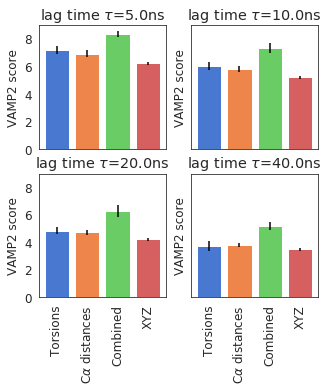

In [44]:
sns.set_style('white')
sns.set_palette('muted')
plt.rcParams['font.size'] = 12

fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True)

for ax, scores, errors, lag in zip(axes.flat, all_scores, all_errors, lags): 
    ax.bar(labels, scores, yerr=errors, color=sns.color_palette("muted"))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_title(r"lag time $\tau$={:.1f}ns".format(lag*0.2))
    ax.set_ylabel("VAMP2 score")
    
plt.savefig('figures/feature_vamp2.pdf', dpi=300, bbox_inches='tight')
plt.show()